# #1 Gibb's Sampling 

In [1]:
import numpy as np
import seaborn as sns


def p_x_given_y(y, mus, sigmas):
    mu = mus[0] + sigmas[1, 0] / sigmas[0, 0] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma)


def p_y_given_x(x, mus, sigmas):
    mu = mus[1] + sigmas[0, 1] / sigmas[1, 1] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)


def gibbs_sampling(mus, sigmas, iter=10000):
    samples = np.zeros((iter, 2))
    y = np.random.rand() * 10

    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]

    return samples


if __name__ == '__main__':
    mus = np.array([5, 5])
    sigmas = np.array([[1, .9], [.9, 1]])

    samples = gibbs_sampling(mus, sigmas)
    sns.jointplot(samples[:, 0], samples[:, 1])

# #2 Metropolis Hastings 

In [2]:
import numpy as np
import scipy.stats as st
import seaborn as sns


mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])


def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2


def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)


def metropolis_hastings(p, iter=1000):
    x, y = 0., 0.
    samples = np.zeros((iter, 2))

    for i in range(iter):
        x_star, y_star = np.array([x, y]) + np.random.normal(size=2)
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star
        samples[i] = np.array([x, y])

    return samples


if __name__ == '__main__':
    samples = metropolis_hastings(circle, iter=10000)
    sns.jointplot(samples[:, 0], samples[:, 1])

    samples = metropolis_hastings(pgauss, iter=10000)
    sns.jointplot(samples[:, 0], samples[:, 1])

# #3 Rejection Sampling 

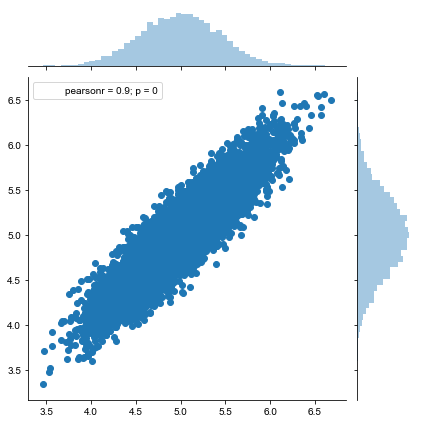

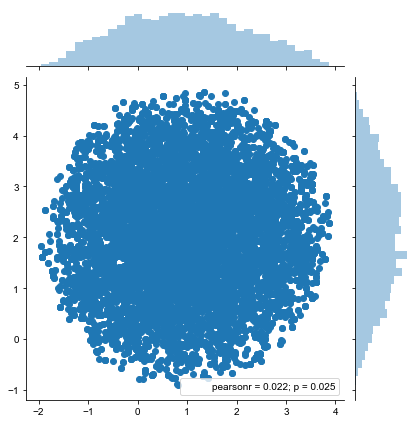

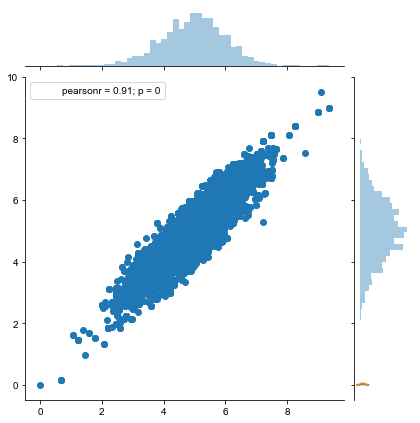

In [3]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()


def p(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)


def q(x):
    return st.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
k = max(p(x) / q(x))


def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, k*q(z))

        if u <= p(z):
            samples.append(z)

    return np.array(samples)


if __name__ == '__main__':
    plt.plot(x, p(x))
    plt.plot(x, k*q(x))
    plt.show()

    s = rejection_sampling(iter=100000)
    sns.distplot(s)

# #4 Stochastic Gradient Langevin Dynamics 

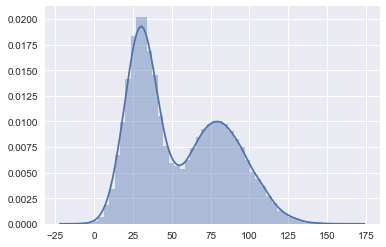

Posterior mean: 1.5016


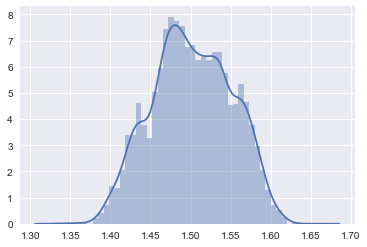

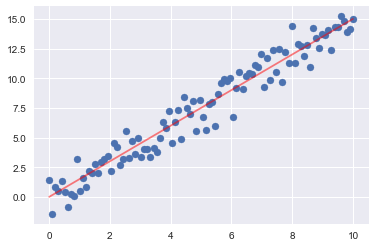

In [4]:
"""
Stochastic Gradient Langevin Dynamics (Welling, Teh, ICML 2011)
---------------------------------------------------------------
Example of simple SGLD sampling the posterior of param of 1D linear regression.
"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


N = 100
n = 50  # minibatch size
true_theta = 1.5

# Noisy data
X = np.linspace(0, 10, num=N)
y = true_theta * X + np.random.randn(N)  # Simple linear regression w/ noise

plt.scatter(X, y)
plt.show()

eps = 0.1  # step size
theta = -60   # initial param

N_iter = 10000

samples = np.zeros(N_iter)
samples[0] = theta

for t in range(1, N_iter):
    mb_idxs = np.random.randint(0, N, size=n)
    x_mb, y_mb = X[mb_idxs], y[mb_idxs]

    eps_t = eps / t  # Annealed learning rate
    eta = np.random.normal(0, np.sqrt(eps_t))  # Noise

    grad_logprior = theta  # prior = N(w | 0, 1)
    grad_loglik = np.sum(y_mb - theta*x_mb)  # lik = N(y | wx, 1)
    grad_logpost = grad_logprior + N/n * grad_loglik  # N/n: scale correction

    delta = eps_t/2 * grad_logpost + eta
    theta = theta + delta

    samples[t] = theta

burnin = 100  # burn-in samples to be discarded
samples = samples[burnin:]

theta_expected = np.mean(samples)

print('Posterior mean: {:.4f}'.format(theta_expected))

sns.distplot(samples)
plt.show()

y_pred = theta_expected*X

plt.scatter(X, y)
plt.plot(X, y_pred, color='red', alpha=0.5)
plt.show()

# #5 Slice Sampling 

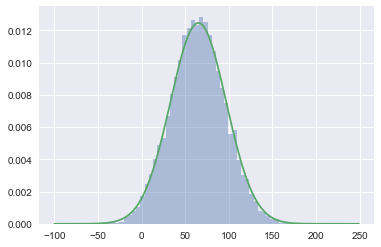

In [5]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
mu = 65
sigma = 32


def p(x):
    return st.norm.pdf(x, loc=mu, scale=sigma)


def p_inv(y):
    x = np.sqrt(-2*sigma**2 * np.log(y * sigma * np.sqrt(2*np.pi)))
    return mu-x, mu+x


def slice_sampling(iter=1000):
    samples = np.zeros(iter)
    x = 0

    for i in range(iter):
        u = np.random.uniform(0, p(x))
        x_lo, x_hi = p_inv(u)
        x = np.random.uniform(x_lo, x_hi)
        samples[i] = x

    return samples


if __name__ == '__main__':
    samples = slice_sampling(iter=10000)
    sns.distplot(samples, kde=False, norm_hist=True)
    x = np.arange(-100, 250)
    plt.plot(x, p(x))
    plt.show()